In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("forecast")) install.packages("forecast")
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("KFAS")) install.packages("KFAS")
if (!require("data.table")) install.packages("data.table")


library("ggplot2")
library("forecast")
library("tidyverse")
library("KFAS")

/home/pranav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/pranav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)
/home/pranav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: forecast

  warnings.warn(x, RRuntimeWarning)
/home/pranav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

  warnings.warn(x, RRuntimeWarning)
/home/pranav/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method   

In [3]:
%%R 
in_df <- read.csv2("time_series_dataset.csv", dec = ".")
in_df$Data <- as.Date(in_df$Data)
head(df)

in_df[in_df$Data=="2012-02-29" | in_df$Data=="2016-02-29",] 
#remove the leap year dates
df <- in_df[-which(in_df$Data=="2012-02-29" | in_df$Data=="2016-02-29"),] 

head(df)

        Data     value
1 2010-01-01  41.65104
2 2010-01-02 131.28660
3 2010-01-03 117.38812
4 2010-01-04 116.46128
5 2010-01-05 123.82376
6 2010-01-06 104.28556


Splittiamo il dataset in train e test per verificare come va il modello su nuovi dati.

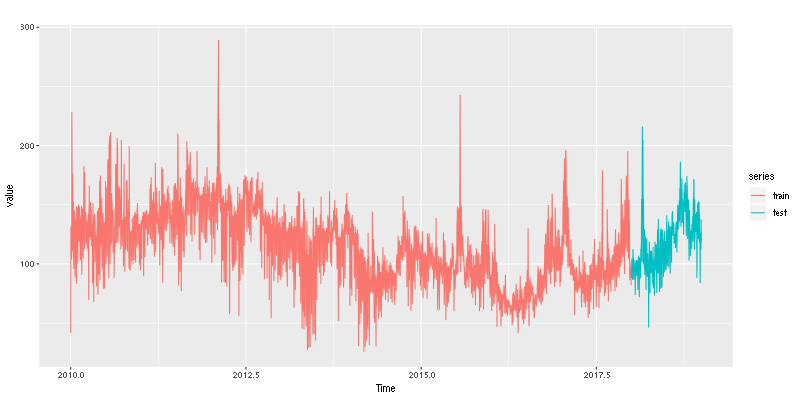

In [4]:
%%R -w 800 -h 400
idata <- ts(df$value, start=c(2010,1), frequency=365) 
train <- window(idata, start=c(2010,1), end=c(2017,365))
#train <- df[1:(nrow(df) - 365),] #last one year is for validation
test <- window(idata, start=c(2018,1), end=c(2018,365))

autoplot(cbind(train, test)) + ylab("value")

# ARIMA with R

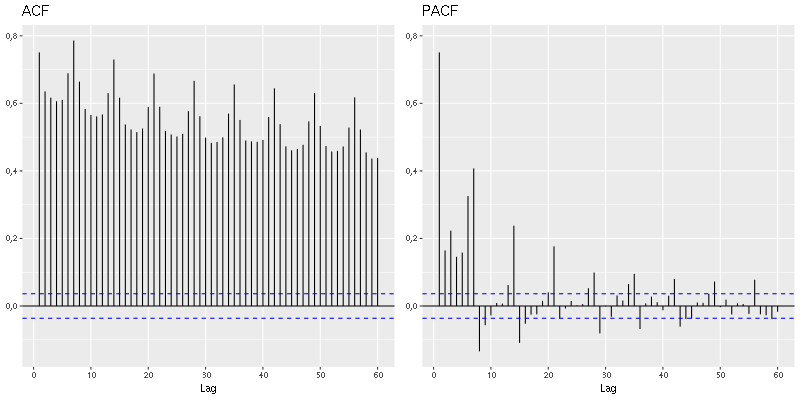

In [6]:
%%R -w 800 -h 400
## ------------------------------------------------------------------------
#This is the function ggtsdisplay of forecast package, 
#but it has been modified so is doesn't plot the series,
#just the ACF and PACF plot, with the horizontal parameter 
#the plot can be either horizontal or vertical
#The function has been simplified a lot, since we don't need 
#all the complexity the original one has.
ggtsdisplay_2 <- function(x, lag.max, horizontal=TRUE, ...) {
    if (!is.ts(x)) {
      x <- ts(x)
    }
    if (missing(lag.max)) {
      lag.max <- round(min(max(10 * log10(length(x)), 3 * frequency(x)), length(x) / 3))
    }
    ######      END   CHECKING    ########
    
    # Set up grid for plots
    if (horizontal){
      gridlayout <- matrix(c(2, 3), nrow = 1)
    }
    else{
      gridlayout <- matrix(c(2, 3), nrow = 2)
    }
    grid::grid.newpage()
    grid::pushViewport(grid::viewport(layout = grid::grid.layout(nrow(gridlayout), ncol(gridlayout))))
    
    # Prepare Acf plot
    acfplot <- do.call(ggAcf, c(x = quote(x), lag.max = lag.max)) +
      ggplot2::ggtitle("ACF") + ggplot2::ylab(NULL)

    # Prepare last plot (variable)
    pacfplot <- ggPacf(x, lag.max = lag.max) + ggplot2::ggtitle("PACF") +
      ggplot2::ylab(NULL)
    # Match y-axis
    acfplotrange <- ggplot2::layer_scales(acfplot)$y$range$range
    pacfplotrange <- ggplot2::layer_scales(pacfplot)$y$range$range
    yrange <- range(c(acfplotrange, pacfplotrange))
    acfplot <- acfplot + ggplot2::ylim(yrange)
    pacfplot <- pacfplot + ggplot2::ylim(yrange)

    # Add ACF plot
    matchidx <- as.data.frame(which(gridlayout == 2, arr.ind = TRUE))
    print(
      acfplot,
      vp = grid::viewport(
        layout.pos.row = matchidx$row,
        layout.pos.col = matchidx$col
      )
    )

    # Add PACF plot
    matchidx <- as.data.frame(which(gridlayout == 3, arr.ind = TRUE))
    print(
      pacfplot,
      vp = grid::viewport(
        layout.pos.row = matchidx$row,
        layout.pos.col = matchidx$col
      )
    )
  
}

ggtsdisplay_2(train, horizontal = TRUE, lag.max = 60)


Possiamo vedere che nel PACF vi sono 7 ritardi e il ritrado stagionale che scende esponenzialemente al settimo ritardo, indicando la presenza di un SMA$(1)_7$ e vedendo ACF dai primi 2 ritardi stagionali ci convinciamo dell'esistenza di SMA$(1)_7$, inoltre vi è presente anche un SAR$(1)_7$. Stagionalità 7 indica un periodo settimanale in questa serie. Inoltre vista la discesa lenta e non geometrica della ACF potrebbe suggerire l'esistenza di una integrazione stagionale. Iniziamo ad aggiungere la parte stagionale prima e cerchiamo di capire dai residui come andrebbe aggiustato il modello.

Series: train 
ARIMA(0,0,0)(1,0,1)[7] with non-zero mean 
Box Cox transformation: lambda= 0,8062425 

Coefficients:
        sar1     sma1     mean
      0,9585  -0,5495  55,6316
s.e.  0,0064   0,0228   1,3456

sigma^2 estimated as 49,58:  log likelihood=-9845,76
AIC=19699,52   AICc=19699,54   BIC=19723,44


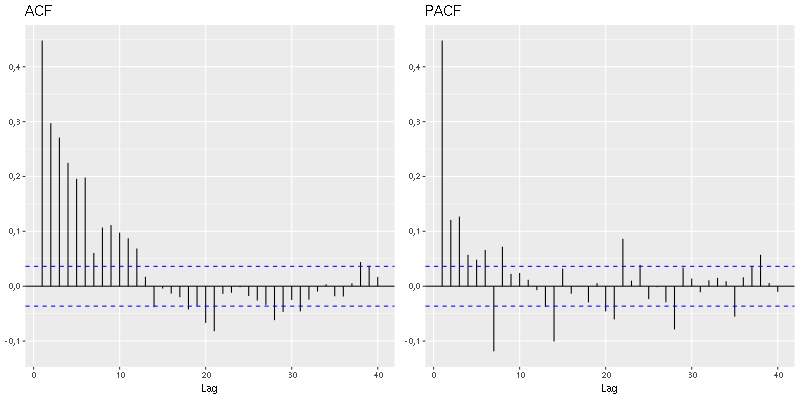

In [7]:
%%R -w 800 -h 400
mod1 <- Arima(train, c(0,0,0), list(order=c(1,0,1), period=7), lambda = "auto")
ggtsdisplay_2(mod1$residuals, lag.max = 40)
mod1

Vediamo anche che il coefficiente di SAR è molto vicino ad 1, quindi ha radice unitaria e ciò dice che esiste l'integrazione stagionale che sospettavamo prima.

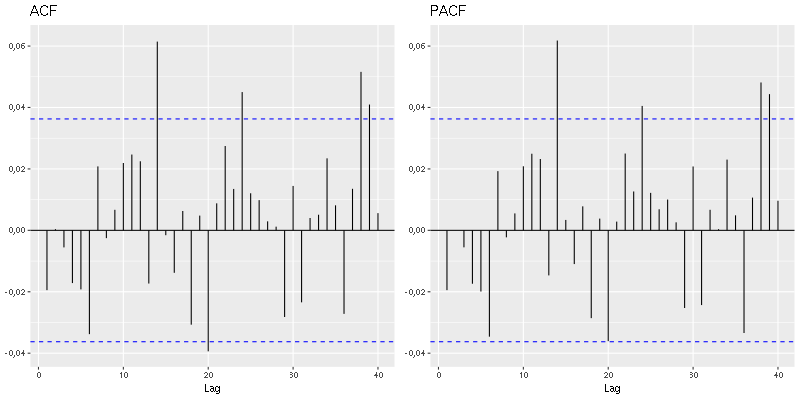

In [8]:
%%R -w 800 -h 400
mod2 <- Arima(train, c(6,0,0), list(order=c(1,1,1), period=7), lambda = "auto")
mod2
ggtsdisplay_2(mod2$residuals, lag.max = 40)

I residui sembrano essere rientrati nella banda tranne un residuo a 14 sia un ACF che PACF.

Usiamo il test Augmented Dickey-Fuller, che cerca radici unitarie nella serie, per verificare se la serie è stazionaria, con k che indica il ritardo autoregressivo, $H_0$ è la presenza di radici unitarie nella serie, $H_1$ è che la serie è stazionaria.


	Augmented Dickey-Fuller Test

data:  mod2$residuals
Dickey-Fuller = -19,907, Lag order = 7, p-value = 0,01
alternative hypothesis: stationary



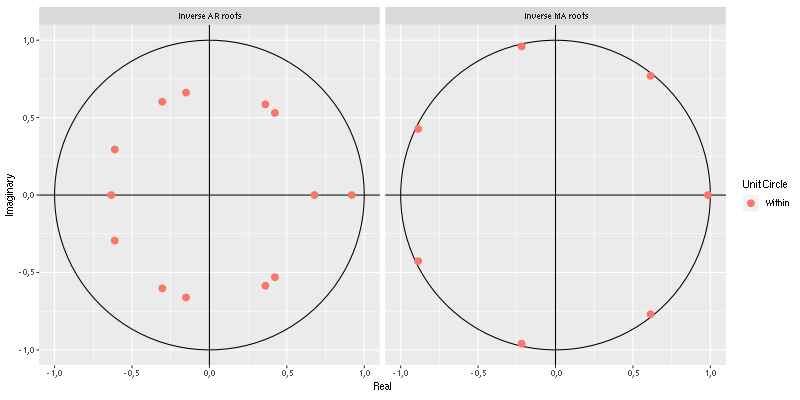

In [14]:
%%R -w 800 -h 400
#Trying Augmeted Dickey-Fuller test to see if the series is stationary:
#$H_0$ is that the model is not stationary
print(tseries::adf.test(mod2$residuals, k=7))
        
#Another way, it shows the roots
autoplot(mod2)

Poiché il p-value è basso rifiutiamo l'$H_0$ e possiamo dire che i residui della sono stazionari. Questo è per il modello AR, mentre per SAR lo abbiamo già visto prima.

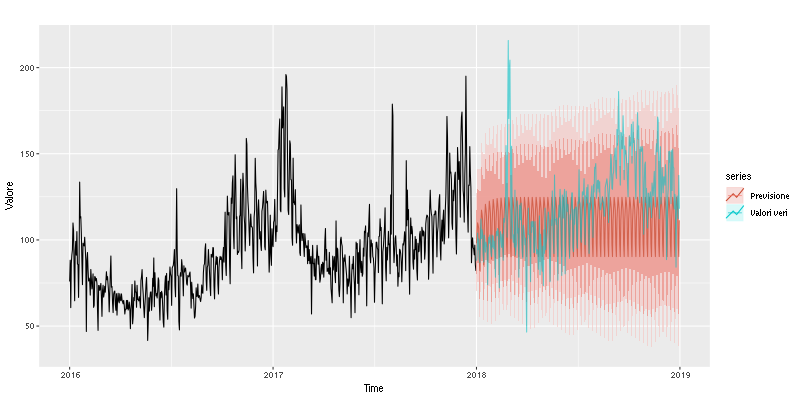

In [10]:
%%R -w 800 -h 400
pred <- forecast(mod2, h=365)

autoplot(window(idata, start=c(2016,1), end=c(2017,365))) +
  autolayer(pred,series="Previsione", alpha=0.7) +
  autolayer(test, series="Valori veri", alpha=0.6) +
  xlab("Time") +
  ylab("Valore")

Questa serie presenta in realtà una multi-stagionalità, che non può essere risolta con R, per questo si prova ad usare regressori esterni, introducendo una stagionalità annuale e ogni 4 settimane quindi mettiamo regressori dummy mensili e ogni 4 settimane.

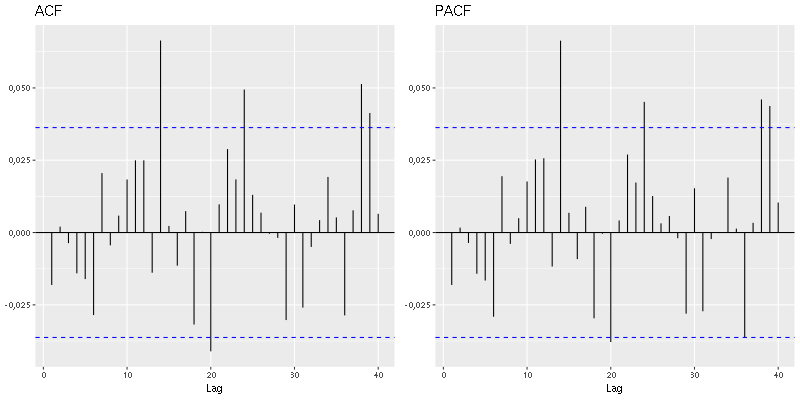

In [11]:
%%R -w 800 -h 400
#create dummy
data.frame(Data=df$Data) %>%
  mutate(M = months(Data), ind = 1) %>%
  spread(M, ind, fill = 0) %>%
  mutate(W = paste0("W",(data.table::week(Data) %% 4 + 1)), ind=1) %>%
  spread(W, ind, fill = 0) %>%
  select(-starts_with("Data")) %>% as.matrix() -> more_reg

#eliminiamo la prima e l'ultima colonna, per evitare multicollinearità
xreg <- more_reg[,2:(ncol(more_reg)-1)] 

mod1_reg <- Arima(train, c(6,0,0), list(order=c(1,1,1), period=7), 
              xreg=xreg[1:(length(train)),], include.constant = TRUE, lambda = "auto")

ggtsdisplay_2(mod1_reg$residuals, lag.max = 40)

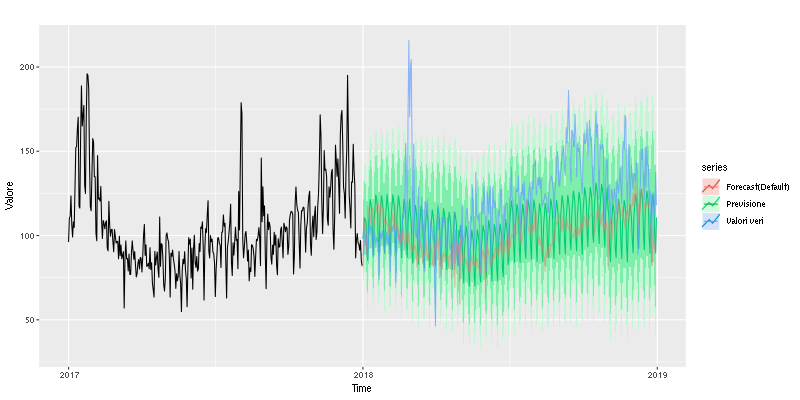

In [12]:
%%R -w 800 -h 400
pred_reg <- forecast(mod1_reg, h=365, 
              xreg=xreg[(length(train)+1):(length(train)+365),])
autoplot(pred_reg)

autoplot(window(idata, start=c(2017,1), end=c(2017,365))) +
  autolayer(pred_reg,series="Previsione") +
  autolayer(test, series="Valori veri", alpha=0.7)+
  autolayer(forecast(train, h=365)$mean, alpha=0.5, series="Forecast(Default)") +
  ylab("Valore")

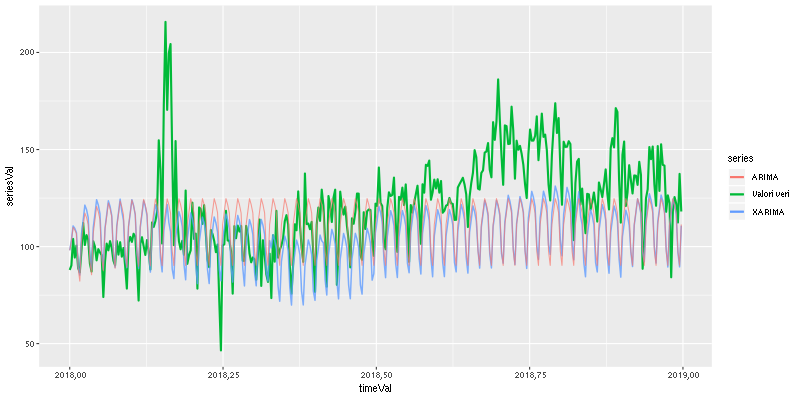

In [13]:
%%R -w 800 -h 400
mod_reg_y <- forecast(mod1_reg, h=365, 
                 xreg=xreg[(nrow(df)-365+1):(length(train)+365),])$mean
mod2_y <- forecast(mod2, h=365)$mean

ggplot() +
  autolayer(test, series="Valori veri", size=1) +
  autolayer(pred_reg$mean,series="XARIMA", size=0.7, alpha=0.8) +
  autolayer(pred$mean,series="ARIMA", alpha=0.7)
  #autolayer(forecast(train, h=365)$mean, alpha=0.7, series="Forecast")

In realtà si nota che il modello performa peggio sul validation se vengono fornite regressori esterni per indicare il mese e la settimana, ciò è dovuto al fatto che nell'ultimo anno l'andamento è diverso dagli ultimi anni, oppure queste variabili non sono tanto esplicative quanto si credeva e aggiungono solo del rumore alla previsione.

# UCM with R

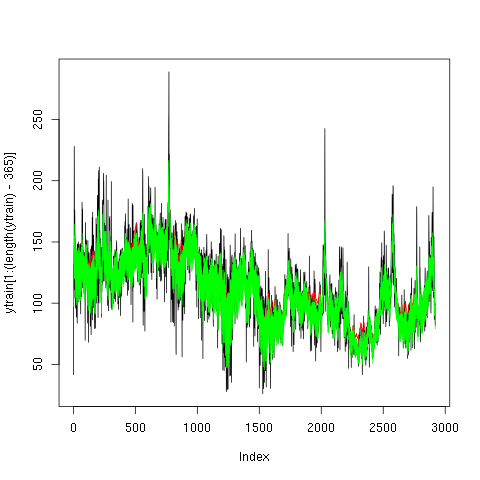

In [19]:
%%R -w 800 -h 400

ytrain <- as.numeric(train)
ytrain[(length(ytrain)+1):(length(ytrain)+365)] <- NA


mod1 <- SSModel(ytrain ~ 0 +
                  SSMtrend(1, NA) +
                  SSMseasonal(7, NA, "dummy") +
                  SSMseasonal(365, 0, "trig",
                              harmonics = 1:12),
                H = NA)

vary <- var(ytrain, na.rm = TRUE)
mod1$P1inf <- mod1$P1inf * 0
mod1$a1[1] <- mean(ytrain, na.rm = TRUE)
diag(mod1$P1) <- vary

# Initial values for the variances we have to estimate
init <- numeric(3)
init[1] <- log(vary/10) # log-var(dist.rw)
init[2] <- log(vary/100)# log-var(dist.seas)
init[3] <- log(vary/10) # log-var(err.oss.)

# Estimate
fit1 <- fitSSM(mod1, init)
fit1$optim.out$convergence

smo1 <- KFS(fit1$model, smoothing = c("state", "disturbance", "signal"))
smo1_seas <- rowSums(smo1$alphahat[1:(length(ytrain) -365), seq(8, 27, 2)])

plot(ytrain[1:(length(ytrain) -365)], type = "l")
lines(smo1$alphahat[1:(length(ytrain) -365), "level"], col = "red")
lines(smo1$alphahat[1:(length(ytrain) -365), "level"] +
        smo1_seas[1:(length(ytrain) -365)], col = "blue")
lines(smo1$alphahat[1:(length(ytrain) -365), "level"] +
        smo1$alphahat[1:(length(ytrain) -365), "sea_dummy1"] +
        smo1_seas[1:(length(ytrain) -365)], col = "green")


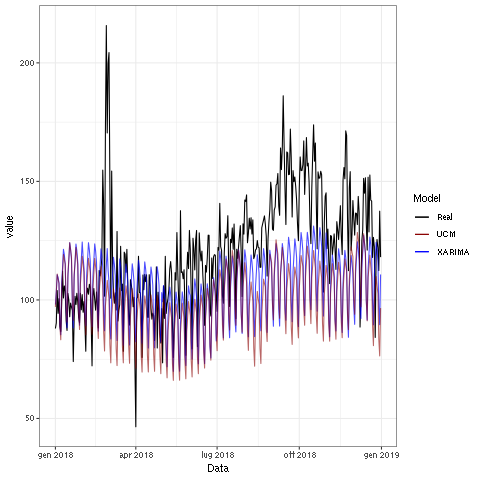

In [20]:
%%R -w 800 -h 400
df[((length(train)+1):length(ytrain)),] %>%
  mutate(UCM = smo1$muhat[(length(train)+1):length(ytrain)],
         XARIMA = as.numeric(pred_reg$mean), 
         ARIMA = as.numeric(pred$mean)) %>%
  ggplot(aes(x=Data)) + 
  geom_line(aes(y=value ,col="Real")) +
  #geom_line(aes(y=ARIMA, col="ARIMA"), linetype="F1") +
  geom_line(aes(y=XARIMA, col="XARIMA"), alpha=0.7) +
  geom_line(aes(y=UCM, col="UCM"), alpha=0.6) +
  scale_color_manual(name = "Model",
                     values= c("Real"="black",
                               "UCM"="darkred",
                               #"ARIMA"="blue",
                               "XARIMA"="blue")) +
  theme_bw()


# LSTM with python

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [39]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, regularizers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='loss', patience=4, verbose=1)
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=2, verbose=1, 
                             factor=0.5, min_lr=1e-5)

from sklearn.preprocessing import MinMaxScaler, StandardScaler

UsageError: Line magic function `%tensorflow_version` not found.


In [47]:
df = pd.read_csv("time_series_dataset.csv", sep=";", decimal=".")
df.Data = pd.to_datetime(df.Data)
df.head()

,Data,value
0,2010-01-01,41.651044
1,2010-01-02,131.286604
2,2010-01-03,117.388117
3,2010-01-04,116.461280
4,2010-01-05,123.823765


In [49]:
df.drop(df[df.Data == "2012-02-29"].index, inplace=True)
df.drop(df[df.Data == "2012-02-29"].index, inplace=True)

In [50]:
train = df[df.Data <= pd.to_datetime("2017-12-31")]
test  = df[df.Data  > pd.to_datetime("2017-12-31")]

In [51]:
train.tail()

,Data,value
2917,2017-12-27,94.68432
2918,2017-12-28,91.35400
2919,2017-12-29,96.96372
2920,2017-12-30,85.41000
2921,2017-12-31,82.01000


In [52]:
test.head()

,Data,value
2922,2018-01-01,87.95964
2923,2018-01-02,90.30000
2924,2018-01-03,103.95000
2925,2018-01-04,94.34287
2926,2018-01-05,100.53000


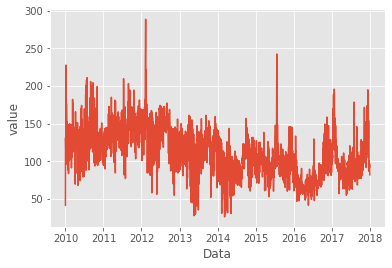

In [24]:
sns.lineplot(train.Data,train.value)
plt.show()

In [ ]:
x_scaler = StandardScaler().\
            fit(np.array(train.value).reshape(-1,1))

x_scaled = x_scaler.transform(np.array(train.value).reshape(-1,1))

In [ ]:
def sliding_windows(data, seq_length, pred_lenght):
    x = []
    y = []

    for i in range(len(data)-seq_length-pred_lenght-1):
        x.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length:i+seq_length+pred_lenght])

    return np.array(x),np.array(y)

In [ ]:
INPUT_SIZE = 365*2 #2 years
OUTPUT_SIZE = 365

In [ ]:
slides = sliding_windows(x_scaled, 
                         INPUT_SIZE ,OUTPUT_SIZE)

X_train = slides[0].reshape(slides[0].shape[0],
                            slides[0].shape[1],
                           1)
y_train = slides[1]

In [29]:
X_train.shape

(1825, 730, 1)

In [30]:
y_train.shape

(1825, 365, 1)

In [ ]:
initial = Input(shape=(INPUT_SIZE,1))

x = LSTM(80, activation='tanh', return_sequences=False,
         kernel_regularizer=regularizers.l1(0.001),
         activity_regularizer=regularizers.l1(0.001))(initial)

#x = LSTM(160, activation='tanh', return_sequences=False,
#         kernel_regularizer=regularizers.l1(0.001),
#         activity_regularizer=regularizers.l1(0.001))(x)

x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)

out = Dense(OUTPUT_SIZE, activation='linear')(x)

model = Model(initial, out)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 730, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 80)                26240     
_________________________________________________________________
dense (Dense)                (None, 512)               41472     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 365)               187245    
Total params: 517,613
Trainable params: 517,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',optimizer=optimizers.RMSprop(learning_rate=0.005), metrics=['mae'])

In [34]:
history = model.fit(X_train, y_train,
                  batch_size=256, epochs=250, 
                  callbacks=[lr_decay, early])

Train on 1825 samples
Epoch 1/250
1825/1825 [==============================] - 8s 4ms/sample - loss: 11.8391 - mae: 1.7326
Epoch 2/250
1825/1825 [==============================] - 0s 216us/sample - loss: 0.6855 - mae: 0.6397
Epoch 3/250
1825/1825 [==============================] - 0s 216us/sample - loss: 0.6594 - mae: 0.6240
Epoch 4/250
1825/1825 [==============================] - 0s 220us/sample - loss: 0.6433 - mae: 0.6162
Epoch 5/250
1825/1825 [==============================] - 0s 218us/sample - loss: 0.6388 - mae: 0.6134
Epoch 6/250
1825/1825 [==============================] - 0s 217us/sample - loss: 0.6576 - mae: 0.6248
Epoch 7/250
1825/1825 [==============================] - 0s 220us/sample - loss: 0.6302 - mae: 0.6085
Epoch 8/250
1825/1825 [==============================] - 0s 217us/sample - loss: 0.6539 - mae: 0.6223
Epoch 9/250
1792/1825 [============================>.] - ETA: 0s - loss: 0.6387 - mae: 0.6147
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0024999999

In [35]:
model.evaluate(X_train, y_train)

1825/1825 [==============================] - 1s 513us/sample - loss: 0.3990 - mae: 0.4541


[0.39902073229828927, 0.45413327]

In [ ]:
train_pred = model.predict(np.expand_dims(X_train[-1], axis=0))[0]

In [37]:
y_train.shape

(1825, 365, 1)

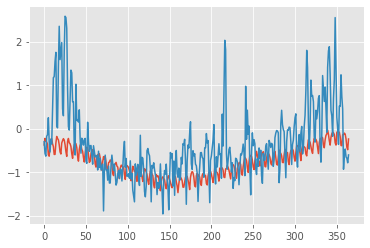

In [38]:
plt.plot(train_pred)
plt.plot(y_train[-1].reshape(365,))

In [ ]:
X_test = np.expand_dims(x_scaled[-365*2:], axis=0)

In [ ]:
pred = model.predict(X_test)[0]

In [ ]:
pred = x_scaler.inverse_transform(pred.reshape(-1,1))

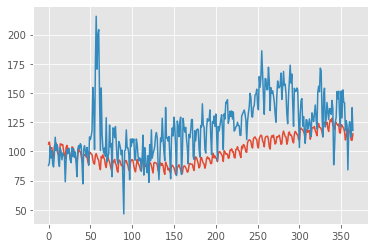

In [42]:
plt.plot(pred)
plt.plot(np.array(test.value))
plt.show()

In [47]:
np.mean((pred - np.array(test.value))**2) #MSE

1135.1454599917377

In [56]:
%%R

ucm_y <- smo1$muhat[(length(train)+1):length(ytrain)]

mse_reg <- mean((test - mod_reg_y)^2)
mse_2   <- mean((test - mod2_y)^2)
mse_ucm   <- mean((test - ucm_y)^2)

print(paste0("MSE relativo modello ARIMA : ", mse_2))
print(paste0("MSE relativo modello XARIMA : ", mse_reg))
print(paste0("MSE relativo modello UCM : ", mse_ucm))

[1] "MSE relativo modello ARIMA : 600.229269670712"
[1] "MSE relativo modello XARIMA : 650.642457897501"
[1] "MSE relativo modello UCM : 861.017046144573"


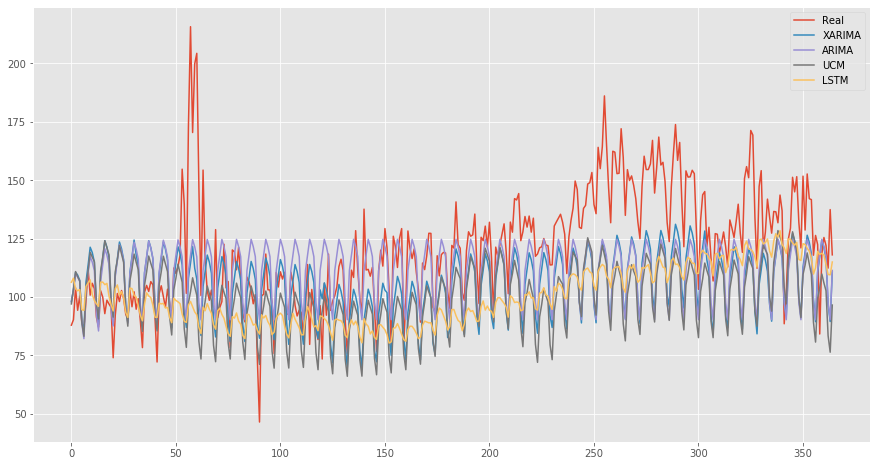

In [62]:
%R -o mod_reg_y -o mod2_y -o ucm_y

plt.figure(figsize=(15,8))
real, = plt.plot(np.array(test.value))
xarima, = plt.plot(np.array(mod_reg_y))
arima, = plt.plot(np.array(mod2_y))
ucm, = plt.plot(np.array(ucm_y))
lstm, = plt.plot(pred)

plt.legend([real,xarima,arima, ucm, lstm],
           ['Real','XARIMA','ARIMA','UCM','LSTM']) 

plt.xlabel("Time")
plt.ylabel("Value")

plt.show()